# Hierarchical Design Patterns

This page covers best practices and design patterns for creating composable dynamical systems models, control algorithms, and other modular functionality using Archimedes.
By leveraging the [`struct`](#archimedes.tree.struct) decorator, you can create modular components that can be combined into complex hierarchical models while maintaining clean, organized code.
However, the recommendations in this guide are strictly suggestions; you can design your models and workflows however you wish.

## Core Concepts

The basic concepts of structured data types and tree operations are covered in the ["Structured Data Types"](../../trees.md) documentation page.
Here we'll build on these concepts to see how they can be used for intuitive and scalable design patterns.

### Trees for structured states

Dynamical systems often have state variables that benefit from logical grouping.
Using tree-structured representations allows you to:

1. Group related state variables together
2. Create nested hierarchies that mirror the physical structure of your system
3. Maintain clean interfaces between subsystems
4. Flatten and unflatten states automatically for ODE solvers

### Design Patterns

Some recommended patterns for building modular dynamics components in Archimedes are:

1. **Modular Components**: Create a [`struct`](#archimedes.tree.struct) for each logical system component
2. **Hierarchical Parameters**: Add model parameters as fields in the struct
3. **Nested State Classes**: Define a `State` class inside each model component
4. **Dynamics Methods**: Implement `dynamics(self, t, state, ...)` methods that return state derivatives
5. **Compositional Models**: Build larger models by combining smaller components

## Basic Component Pattern

Here's a basic example of using these patterns to creating a modular dynamical system component:

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

import archimedes as arc
from archimedes import struct

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)


@struct
class Oscillator:
    """A basic mass-spring-damper component."""

    # Define model parameters as fields in the struct
    m: float  # Mass
    k: float  # Spring constant
    b: float  # Damping constant

    # Define a nested State class as another struct
    @struct
    class State:
        """State variables for the mass-spring-damper system."""

        x: np.ndarray
        v: np.ndarray

    def dynamics(self, t, state: State, f_ext=0.0):
        """Compute the time derivatives of the state variables."""

        # Compute derivatives
        f_net = f_ext - self.k * state.x - self.b * state.v

        # Return state derivatives in the same structure
        return self.State(
            x=state.v,
            v=f_net / self.m,
        )


system = Oscillator(m=1.0, k=1.0, b=0.1)
x0 = system.State(x=1.0, v=0.0)
x0

Oscillator.State(x=1.0, v=0.0)

For such a simple system, the advantages to this design are relatively limited, but because these nodes can be nested within each other, it can be a useful way to organize states, parameters, and functions associated with complex models.

## Working with tree-structured data

Many functions like ODE solvers expect to work with flat vectors.
Tree operations in Archimedes make conversion to and from flat vectors easy.
For example, we can "ravel" a tree-structured state to a vector and "unravel" back to the original state:

In [2]:
x0_flat, unravel = arc.tree.ravel(x0)
print(x0_flat)
print(unravel(x0_flat))

[1. 0.]
Oscillator.State(x=array(1.), v=array(0.))


The `unravel` function created by [`tree.ravel`](#archimedes.tree.ravel) is specific to the original argument data type, so it can be used within ODE functions, for example:

In [3]:
@arc.compile
def ode_rhs(t, state_flat, system):
    # Unflatten the state vector to our structured state
    state = unravel(state_flat)

    # Compute state derivatives using model dynamics
    state_deriv = system.dynamics(t, state)

    # Flatten derivatives back to a vector
    state_deriv_flat, _ = arc.tree.ravel(state_deriv)

    return state_deriv_flat


# Solve the ODE
t_span = (0.0, 10.0)
t_eval = np.linspace(*t_span, 100)
solution_flat = arc.odeint(
    ode_rhs,
    t_span=t_span,
    x0=x0_flat,
    t_eval=t_eval,
    args=(system,),
)

Since the model itself is also a [`struct`](#archimedes.tree.struct), we can also apply [`ravel`](#archimedes.tree.ravel) directly to it, giving us a flat vector of the parameters defined as fields:

In [4]:
p_flat, unravel_system = arc.tree.ravel(system)
print(p_flat)  # [1.  1.  0.1]

[1.  1.  0.1]


This is useful for applications in optimization and parameter estimation.

Another common pattern is to define yet another `struct` for the parameters, rather than having them as fields in the system model.
This comes down to individual preference and whatever works best for the specific application.

## Complete Example: Coupled Oscillators

Larger systems can be built by composing multiple components together.
Let's build a system of coupled oscillators to demonstrate these patterns.

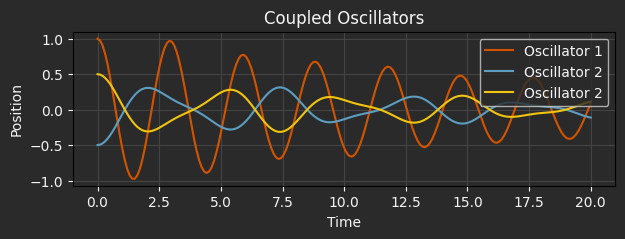

In [ ]:
@struct
class CoupledOscillators:
    """A system of two coupled oscillators."""

    osc1: Oscillator
    osc2: Oscillator
    coupling_constant: float

    @struct
    class State:
        """Combined state of both oscillators."""

        osc1: Oscillator.State
        osc2: Oscillator.State

    def dynamics(self, t, state):
        """Compute dynamics of the coupled system."""
        # Extract states
        x1 = state.osc1.x
        x2 = state.osc2.x

        # Compute equal and opposite coupling force
        f_ext = self.coupling_constant * (x2 - x1)

        return self.State(
            osc1=self.osc1.dynamics(t, state.osc1, f_ext),
            osc2=self.osc2.dynamics(t, state.osc2, -f_ext),
        )


# Create a coupled oscillator system
system = CoupledOscillators(
    osc1=Oscillator(m=1.0, k=4.0, b=0.1),
    osc2=Oscillator(m=1.5, k=2.0, b=0.2),
    coupling_constant=0.5,
)

# Create initial state
x0 = system.State(
    osc1=Oscillator.State(x=1.0, v=0.0),
    osc2=Oscillator.State(x=-0.5, v=0.0),
)

# Flatten the state for ODE solver
x0_flat, state_unravel = arc.tree.ravel(x0)


# ODE function that works with flat arrays
@arc.compile
def ode_rhs(t, state_flat, system):
    state = state_unravel(state_flat)
    state_deriv = system.dynamics(t, state)
    state_deriv_flat, _ = arc.tree.ravel(state_deriv)
    return state_deriv_flat


# Solve the system
t_span = (0.0, 20.0)
t_eval = np.linspace(*t_span, 200)
sol_flat = arc.odeint(
    ode_rhs,
    t_span=t_span,
    x0=x0_flat,
    t_eval=t_eval,
    args=(system,),
)

# Postprocessing: create a "vectorized map" of the unravel
# function to map back to the original tree-structured state
sol = arc.vmap(state_unravel, in_axes=1)(sol_flat)

# Plot the results
plt.figure(figsize=(7, 2))
plt.plot(t_eval, sol.osc1.x, label="Oscillator 1")
plt.plot(t_eval, sol.osc2.x, label="Oscillator 2")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Coupled Oscillators")
plt.legend()
plt.grid(True)
plt.show()

## Summary

The recommended approach to building hierarchical and modular dynamical systems in Archimedes follows these key patterns:

1. Use [`@struct`](#archimedes.tree.struct) to define structured component classes
2. Create nested `State` classes to organize state variables
3. Implement `dynamics` methods that compute state derivatives
4. Compose larger systems from smaller components
5. Add helper methods to simplify simulation and analysis

Other best practices include:

1. **Consistent Interfaces**: Keep the `dynamics(self, t, state, *args)` method signature consistent across all components
2. **Immutable States**: Always return new state objects instead of modifying existing ones
3. **Physical Units**: Document physical units in comments or docstrings
4. **Input Validation**: Add validation in constructors to catch errors early
5. **Meaningful Names**: Use descriptive names that reflect physical components, or consistent pseudo-mathematical notation like the [monogram](https://drake.mit.edu/doxygen_cxx/group__multibody__notation__basics.html) convention
6. **Domain Decomposition**: Decompose complex systems into logical components (mechanical, electrical, etc.)
7. **Structured Parameters**: Define physical parameters as fields in the structs, and use the [`field(static=True)`](#archimedes.tree.field) annotation to mark configuration variables.


These patterns enable clean, organized, and reusable model components by leveraging Archimedes' tree operations to handle the conversion between structured and flat representations needed by ODE solvers.